# Importing



In [ ]:
#######################################################################
# Imports
#######################################################################
!pip install -q fer
!pip install -q cvzone

import logging
#This is going to help log information throughout our program. 
logging.basicConfig(
        level=logging.INFO, format="%(asctime)s %(levelname)s:%(message)s"
    )
logging.info("Loading libraries, takes aproximately 4 seconds.")


# Libraries that will be needed for everything to run
import cv2 as cv # used for handling the image aspect
import tarfile # used to untar the model downloaded
import shutil
import urllib.request # used to download
import os # file handling
import tensorflow as tf # used for detections model
import numpy as np # V1.2, added to fix adv noise saving.
import urllib
import urllib.request
from imgaug import augmenters
import matplotlib.pyplot as plt
from fer import FER
logging.info('Done.')


2022-07-27 14:55:09,210 INFO:Loading libraries, takes aproximately 4 seconds.
2022-07-27 14:55:09,213 INFO:Done.


# Model



In [ ]:

class Model():
#Initiate Facial Expression Recognizer Model
#more accurate MTCNN network 
  
  def __init__(self):
    from fer import FER


    self.fer_model=FER(mtcnn=True)
    self.emotion_detector=self.fer_model.detect_emotions
    self.emotion_model=FER(mtcnn=True)
    self.download_model()
    self.model = self.initialize_model()

#######################################################################
#
#     Function that downloads models,
#     Input: Base Url, File name Outputs: None. 
#     Purpose:Downloads files
#
#######################################################################
  def Download(self,base_url, file_name):
    # checks if file exists

    if file_name not in os.listdir():
    
      #logs what is about to happen
      logging.info('Downloading ' + file_name) 
      
      #builds url
      url = base_url + file_name
      
      #retrieves what ever was in url by downloading it ...
      urllib.request.urlretrieve(url, file_name)
      logging.info('Download Complete')
      
      #This part checks it is is a tar file, a tar file is bunched up. 
      if file_name.find('.tar.gz') != -1:
        logging.info("Extracting " + file_name)
      
      # we are naming the the directory
      dir_name = file_name[0:-len('.tar.gz')]
      
      #check to see if path exist.
      if os.path.exists(dir_name):

      #if it does we want to erase the entire tree using shutil.rmtree
        shutil.rmtree(dir_name) 
      
      # Now we want to open the tarfile and extract all the information 
      tarfile.open(file_name, 'r:gz').extractall('./')
      
      #log extraction complete 
      logging.info("Extraction Complete")
    
    
    #if the file exist then we can  
    else:
      logging.info(file_name + ' already exists.')

#######################################################################
#
#   download_model  Inputs: None    Outputs: None     
#   
#######################################################################
  
  def download_model(self):
    #makes a call to download label.txt
    self.Download('https://raw.githubusercontent.com/nightrome/cocostuff/master/','labels.txt')
    #makes a call to download model
    self.Download('http://download.tensorflow.org/models/object_detection/', 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz')

#######################################################################

#######################################################################
# initialize_model    
# Inputs: None      
# Outputs: Returns a model that accepts one input. That model accepts tensored images... it then returns the detections  
#
#######################################################################  
  def initialize_model(self):
    #this is a preprocessing function need to help with the frozen graph
    def wrap_graph(graph_def, inputs, outputs, print_graph=False):
      wrapped = tf.compat.v1.wrap_function(lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])
      
      return wrapped.prune(
          tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
          tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))
    
    
    # This is the format that we want outputs to follow  
    outputs = (
      'num_detections:0',
     'detection_classes:0',
     'detection_scores:0',
     'detection_boxes:0',
    )

    
    #We need to load a pre-trained model... This is done with the following. We care about frozen_inference_graph.pb because it holds a trained Tensor Flow graph that we can use for classification.
    frozen_graph = os.path.join('ssd_mobilenet_v1_coco_2018_01_28', 'frozen_inference_graph.pb')
    
    #This part of the code allows us to read the frozen graph (model). As you can see it saves and loads the file. the first part instantiates and the second part used parsefromstring in order to 
    #this part allows us to go through the file
    with tf.io.gfile.GFile(frozen_graph, "rb") as f:
      
      #This initializes a GraphDef which will be used to help with the loading part
      graph_def = tf.compat.v1.GraphDef()
      
      #This reads the files that we have
      loaded = graph_def.ParseFromString(f.read())

      #This used the frozen graph part and this makes the model. 
      model = wrap_graph(graph_def=graph_def, inputs=["image_tensor:0"], outputs=outputs)
      return model

#######################################################################

# Image Class


In [19]:


class Image():


  # We can modify priv_class in order to change things that we may want to add to the privacy scale.   
#######################################################################

  def get_image(self, image_path):
    #   Purpose: Gets image from what is passed in 
    #   Input: image_path or url
    #   Output: cv2 image
    
    if image_path in os.listdir():
      image = cv.imread(image_path)
      image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
    else:
      req = urllib.request.urlopen(image_path)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      image = cv.imdecode(arr, -1)
    
    return image


#                       VIPER Helpers
#######################################################################


  def priv_or_not(self,box_class):
    #   Purpose:  
    #   Used for a loop in blur to verify that our boxed detection is in our priv_class list 
    #   Input:  box_class (The detection class that our individual box is in)
    #   Output: Boolean           
    
    if box_class in self.priv_class:
      return True      
    else:
      return False

#######################################################################

  def object_blur(self, cv2_image, x1, x2, y1, y2, blurAmount):
    #Purpose:
    #Used for a loop in blur to Blur an object 
    #We call on this function repeatedly for every detection box in our detection.        
    #defines the outline of what we want to blur
    blurred_object = cv2_image[y1:y2,x1:x2]
    #This is the amount we want to blur 
    ksize = (blurAmount,blurAmount) 
    #We transform what we have in or outline into a blurred object  
    blurred_object = cv.blur(blurred_object, ksize, cv.BORDER_DEFAULT)    
    #We modify the section of the image to our blurred out version.
    cv2_image[y1:y2,x1:x2] = blurred_object
    #Returns the image

    return cv2_image


#######################################################################


  def image_saver(self):
    self.modified = cv.cvtColor(self.modified ,cv.COLOR_BGR2RGB)
    cv.imwrite('image.jpg',self.modified)


#######################################################################


  def box_to_pixels(self, box_bounds, cv2_image):
    #This function takes in box bound and an image, then it turn it into a coordinate
    #This allows us to border out what we want to pixalize. 
        
    y1 = int((box_bounds[0]*cv2_image.shape[0]).numpy())
    x1 = int((box_bounds[1]*cv2_image.shape[1]).numpy())
    y2 = int((box_bounds[2]*cv2_image.shape[0]).numpy())
    x2 = int((box_bounds[3]*cv2_image.shape[1]).numpy())
    
    return [x1,x2,y1,y2]


#######################################################################
#Heavy lifting, This function does the bluring using a for loop
#######################################################################


  def blur(self,blur_amount=300):
    #REDUCES RUN TIME BY ONLY RUNNING MODEL IF NECESSARY
    if self.tensor== None:
      self.tensor = tf.convert_to_tensor([self.image], dtype=tf.uint8)
      self.detections = self.model(self.tensor)
      self.num_of_detections= len([x for x in self.detections[3][0] if not ((x == self.detections[2][0][-1])[0])])
    self.blur_amount=blur_amount
    for i in range(self.num_of_detections):
        
      single_box = self.detections[3][0][i]
      box_class = self.detections[1][0][i]
      
      if self.priv_or_not(box_class): 
        
        left, right, top, bottom = self.box_to_pixels(single_box, self.image)
        self.modified=self.object_blur(self.image,left, right, top, bottom, self.blur_amount)
        #self.image_saver()


#######################################################################
#######################################################################
  # block


  def object_block(self,image, x1, x2, y1, y2, color):
    thickness = -1
    image=cv.rectangle(image,(x1,y1),(x2,y2), color, thickness)

    return image




  def block(self,color=(0,0,0)):
    #REDUCES RUN TIME BY ONLY RUNNING MODEL IF NECESSARY
    if self.tensor== None:
      self.tensor = tf.convert_to_tensor([self.image], dtype=tf.uint8)
      self.detections = self.model(self.tensor)
      self.num_of_detections= len([x for x in self.detections[3][0] if not ((x == self.detections[2][0][-1])[0])])
    
    self.color = color
    for i in range(self.num_of_detections):
      box = self.detections[3][0][i]
      box_class = self.detections[1][0][i]

    
      if self.priv_or_not(box_class):
        left, right, top, bottom = self.box_to_pixels(box, self.image)
        self.modified=self.object_block(self.image, left, right, top, bottom, self.color)
        #self.image_saver()

#######################################################################


  def noise(self,noise_amount=.6):
    self.noise_amount=noise_amount
    noise= augmenters.SaltAndPepper(self.noise_amount)
    seq=augmenters.Sequential([noise])
    self.modified=seq.augment_image(self.image)
    
    #self.image_saver()
#######################################################################

#######################################################################
  def import_emoji(self):
    for x in self.emoji_keys:
      name= cv.imread(( x + '.png'), cv.IMREAD_UNCHANGED)
      name= cv.cvtColor(name, cv.COLOR_BGRA2RGBA)
      self.emoji_dict[x]=name 


#######################################################################
  def coordinates(self,box):
    left = box[0]
    bottom = box[1]
    right= left + box[2]
    top= bottom+box[3]
    return [left, bottom, right, top]
  def face2emoji(self, cropped_image,emotion):
    size = cropped_image.shape
    size= (size[1],size[0])
    max_emotion = max(emotion, key=emotion.get)
    emoji = self.emoji_dict[str(max_emotion)]
    emoji=cv.resize(emoji,size)
    cropped_image = cvzone.overlayPNG(cropped_image,emoji,(0,0))
    return cropped_image

  def emoji(self):
    if self.result== None:
      self.result=model.emotion_detector(self.image)
      self.import_emoji()    
    self.modified= self.image.copy()
    for i in range(len(self.result)):
      emotion=self.result[i]['emotions']
      box=self.result[i]['box']
      left, bottom, right, top= self.coordinates(box)
      cropped_image= self.modified[bottom:top,left:right]
      cropped_image= self.face2emoji(cropped_image,emotion)
      
      self.modified[bottom:top,left:right]  = cropped_image

#######################################################################

  def __init__(self, model, image_path):
    self.image= self.get_image(image_path)
    self.tensor = None
    self.model= model.model
    self.detections = None
    self.blur_amount=300
    self.noise_amount=.6
    self.priv_class=[12, 14, 30, 33, 46, 63, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 85, 110, 133,31,69,3]
    self.color = (0, 0, 0)
    self.num_of_detections= None
    self.modified=None 
    
                    #Emotion detection#
    ################################################################### 
    
    self.result=None  
    self.emoji_keys=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    self.emoji_dict={}
    






# Initialize Model


In [ ]:
#######################################################################
#     We need a way to initialize the model and the name it something in order to pass it into the image class
#     Once we pass it into the image class we can then get the num of detections and so forth.
#######################################################################

model= Model()


2022-07-27 14:57:02,914 INFO:labels.txt already exists.
2022-07-27 14:57:02,917 INFO:Downloading ssd_mobilenet_v1_coco_2018_01_28.tar.gz
2022-07-27 14:57:03,396 INFO:Download Complete
2022-07-27 14:57:03,399 INFO:Extracting ssd_mobilenet_v1_coco_2018_01_28.tar.gz
2022-07-27 14:57:04,362 INFO:Extraction Complete


# Initialize Image Class... pass in image and model 


In [20]:
Group=Image(model, "group.jpg")

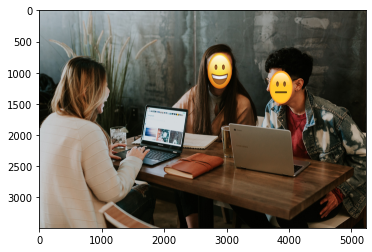

In [ ]:
Group.emoji()


In [23]:
Group.blur(50)

In [25]:
Group.block()

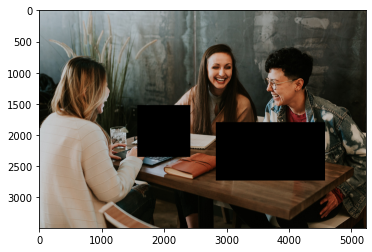

In [26]:
plt.imshow(Group.modified)